In [35]:
import pandas as pd
import requests
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
import numpy as np
from collections import Counter
import utils


In [36]:
# Setting default parameters for all charts
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = 'darkblue'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelcolor'] = 'gray'

# Other optional settings for consistent styling
plt.rcParams['xtick.labelsize'] = 12  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 12  # Font size for legend
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size

# To apply grid and color consistency
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['axes.grid'] = True

plt.style.use('ggplot')
pd.set_option('display.max_columns',None)

# 1. Prilimnary Data Engineering (Raw Count Data)

In [138]:
def getTotalCars(row:pd.DataFrame)->float:
     
    """
    Calculates the total number of Passenger Car Equivalents (PCE) for various types of vehicles on the road.

    This function uses Passenger Car Equivalent (PCE) values to convert diverse vehicle types 
    (e.g., bicycles, motorbikes, buses, and trucks) into an equivalent measure based on the 
    impact of a single passenger car. This allows for standardized comparison of mixed-traffic flow.

    Parameters:
    ----------
    row : pd.DataFrame
        A DataFrame row containing vehicle count data with specific columns for each vehicle type 
        (e.g., `pedal_cycles`, `two_wheeled_motor_vehicles`, `cars_and_taxis`, etc.).

    Returns:
    -------
    float
        The total Passenger Car Equivalent (PCE) count for the input vehicles, providing a measure 
        of traffic flow impact in terms of passenger car units.

    Notes:
    ------
    PCE factors used for different vehicles:
    - pedal_cycles: 0.2
    - two_wheeled_motor_vehicles: 0.6
    - cars_and_taxis: 1.0
    - buses_and_coaches: 2.5
    - lgvs (Light Goods Vehicles): 1.2
    - hgvs with various axles: ranging from 1.8 to 4.2

    The specific values may vary based on region or local guidelines in traffic engineering.
    """

    total_cars=(row['pedal_cycles'] * utils.PEDAL_CYCLES
                +row['two_wheeled_motor_vehicles'] * utils.TWO_WHEELED_MOTOR_VEHICLES
                +row['cars_and_taxis'] * utils.CARS_AND_TAXIS
                +row['buses_and_coaches'] * utils.BUSES_AND_COACHES
                +row['lgvs'] * utils.LGVS
                +row['hgvs_2_rigid_axle'] * utils.HGVS_2_RIGID_AXLE
                +row['hgvs_3_rigid_axle'] * utils.HGVS_3_RIGID_AXLE
                +row['hgvs_4_or_more_rigid_axle'] * utils.HGVS_4_OR_MORE_RIGID_AXLE
                +row['hgvs_3_or_4_articulated_axle'] * utils.HGVS_3_OR_4_ARTICULATED_AXLE
                +row['hgvs_5_articulated_axle'] * utils.HGVS_5_ARTICULATED_AXLE
                +row['hgvs_6_articulated_axle'] * utils.HGVS_6_ARTICULATED_AXLE)
    return total_cars

def getRoadCapacity(row):
    road_capacity_info = {
    "A": {
        "description": "Primary Roads (Arterial)",
        "typical_lanes": "2 lanes",
        "capacity_per_lane": "1,500–2,000 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_A
    },
    "B": {
        "description": "Secondary Roads (Collector roads)",
        "typical_lanes": "1 lane",
        "capacity_per_lane": "800–1,500 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_B
    },
    "U": {
        "description": "Unclassified Roads (Minor local roads)",
        "typical_lanes": "1 lane",
        "capacity_per_lane": "200–800 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_U
    },
    "C": {
        "description": "Local/Residential Roads",
        "typical_lanes": "1 lane",
        "capacity_per_lane": "200–800 vehicles/hour",
        "avg_capacity_per_lane":utils.AVG_ROAD_CAPACITY_C
    }
}
    

    return road_capacity_info[row['road_classification']]['avg_capacity_per_lane']


## 1.1 Reading Raw Count Data and Count Point Metadata

In [139]:
df=pd.read_csv('data/raw_count.csv',parse_dates=['count_date']) # Reading Raw Count Data
count_df=pd.read_csv('data/count_points.csv') # Reading processed count point data
count_df=count_df[count_df['count_point_id'].isin(df['count_point_id'].unique())]
count_df

,count_point_id,region_id,region_name,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,lanes,width,fwd_lanes,bkwd_lanes,max_speed,std_lane_width_meters,oneway,carriageway_type
0,998097,6,London,108,Wandsworth,C,Minor,NaN,NaN,525020,173960,51.450833,-0.202202,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
1,998071,6,London,108,Wandsworth,U,Minor,NaN,NaN,523303,174410,51.455254,-0.226743,NaN,NaN,2.0,NaN,NaN,NaN,32,3.0,NaN,residential
2,998065,6,London,108,Wandsworth,B237,Minor,NaN,NaN,528100,173968,51.450217,-0.157899,NaN,NaN,NaN,NaN,NaN,NaN,32,3.0,NaN,secondary
3,990355,6,London,108,Wandsworth,C,Minor,NaN,NaN,526080,174220,51.452935,-0.186863,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,NaN,NaN
4,953192,6,London,108,Wandsworth,U,Minor,NaN,NaN,528346,175841,51.466994,-0.153682,NaN,NaN,1.0,NaN,NaN,NaN,32,3.0,NaN,residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,7571,6,London,108,Wandsworth,A3036,Major,A3220,LA Boundary,528000,175600,51.464905,-0.158747,0.8,0.50,NaN,NaN,NaN,NaN,0,3.5,NaN,NaN
118,6774,6,London,108,Wandsworth,A217,Major,A24,A3,526600,172000,51.432866,-0.180177,4.2,2.61,NaN,NaN,NaN,NaN,0,3.5,NaN,NaN
119,6757,6,London,108,Wandsworth,A205,Major,A219,A3,524500,174850,51.458945,-0.209369,1.1,0.68,2.0,NaN,NaN,NaN,32,3.5,NaN,trunk
120,6111,6,London,108,Wandsworth,A3,Major,A205,A218,525000,174600,51.456588,-0.202264,0.4,0.25,NaN,NaN,NaN,NaN,0,3.5,no,NaN


In [140]:

print(df[['region_id','region_name','local_authority_id','local_authority_name']].nunique())

# Dropping columns 'region_id', 'region_name', 'local_authority_id', 'local_authority_name' as each has a single unique value,
# which will not contribute to the model's predictive power.
df.drop(columns=['region_id','region_name','local_authority_id','local_authority_name'],inplace=True)

# Applying the function 'getTotalCars' across each row to calculate 'total_cars' based on Passenger Car Equivalent (PCE) values,
# a standard measure in traffic engineering to represent vehicle counts in terms of equivalent car units.
df['total_cars']=df.apply(getTotalCars,axis=1) 
df['road_classification']=df['road_name'].apply(lambda x: x[0]) # Getting the road classification (A, B, C, U)
df['avg_road_capacity']=df.apply(getRoadCapacity,axis=1) # Calculating average road capacity depending upon the road classification as per UK Design Manual for Roads and Bridges (DMRB)
df['congestion_ratio']=df['total_cars']/df['avg_road_capacity'] # Calculating road congestion based on the total cars/hour and average road capacity 

region_id               1
region_name             1
local_authority_id      1
local_authority_name    1
dtype: int64


## 2. Exploratory Data Analysis


In [141]:

# Creating a summary DataFrame 'tdf' to analyze year data availability for each unique road count point.
# The code groups data by 'count_point_id' and collects all unique years of data availability for each point.

tdf=pd.DataFrame(df.groupby(['count_point_id'])['year'].unique()).reset_index() # Groups by 'count_point_id' and lists unique years for each

# Calculating and adding columns to summarize year information for each count point:
tdf['total_years'] = tdf['year'].apply(len) # Counts the total number of unique years with data for each count point
tdf['min_year'] = tdf['year'].apply(min) # Finds the earliest (oldest) year with data availability
tdf['max_year'] = tdf['year'].apply(max) # Finds the latest (most recent) year with data availability
tdf[tdf['max_year']>2013]
tdf

,count_point_id,year,total_years,min_year,max_year
0,6109,"[2002, 2011, 2016, 2021]",4,2002,2021
1,6111,"[2004, 2009, 2010, 2012, 2013, 2017, 2021]",7,2004,2021
2,6757,"[2007, 2011, 2017]",3,2007,2017
3,6774,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",12,2000,2022
4,7571,"[2002, 2012, 2020]",3,2002,2020
...,...,...,...,...,...
106,953192,"[2000, 2001, 2002, 2003, 2004, 2005, 2007, 200...",9,2000,2009
107,990355,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
108,998065,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
109,998071,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",9,2000,2009


### 3.1 Trends in Sensor Data Availability Over Time (2000-2023)

The plot titled "Data Availability Over Time Across Sensors" illustrates the number of sensors (out of a total of 111) with data available for each year from 2000 to 2023. The x-axis represents each year, while the y-axis shows the count of sensors reporting data in that year. A fluctuating blue line with labeled points highlights the variation in data availability, peaking at 46 sensors in a particular year, while other years, such as around 2015 and 2020, show a notable decline in sensor coverage. This plot provides a clear view of data availability trends over time, showing periods of extensive data collection contrasted with years where fewer sensors contributed data.

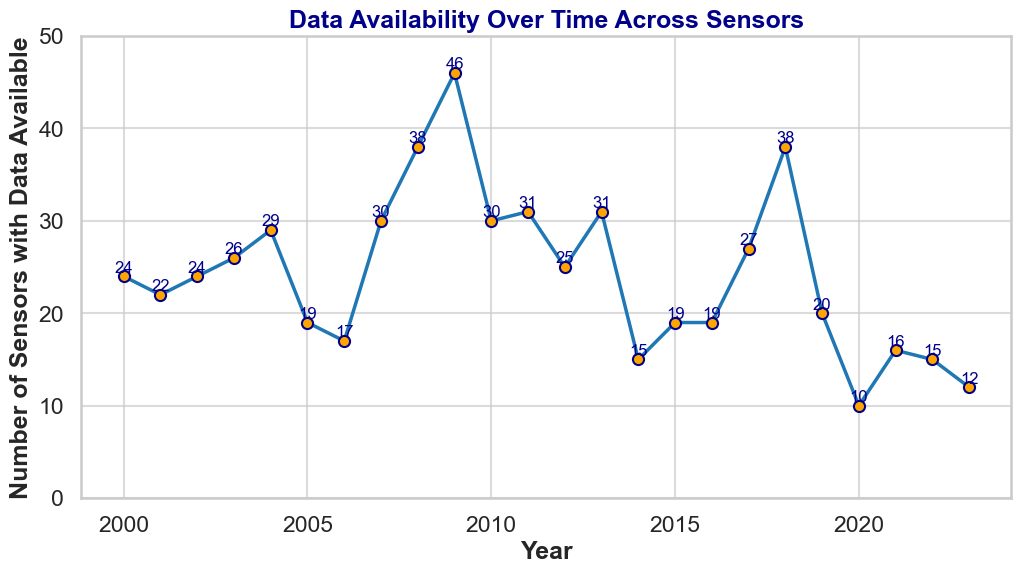

In [142]:
# Flattening the 'year' column to count the occurrence of each year across all sensors
years = [year for sublist in tdf['year'] for year in sublist]
year_counts = Counter(years)

# Creating lists for plotting
years_sorted = sorted(year_counts.keys())
sensor_counts = [year_counts[year] for year in years_sorted]


plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", context="talk")
plt.plot(years_sorted, sensor_counts, marker='o', linestyle='-', color='#1f77b4', linewidth=2.5, markersize=8, markerfacecolor='orange', markeredgewidth=1.5, markeredgecolor='darkblue')

plt.title("Data Availability Over Time Across Sensors")
plt.xlabel("Year")
plt.ylabel("Number of Sensors with Data Available")
for year, count in zip(years_sorted, sensor_counts):
    if count > 1:
        plt.text(year, count + 0.1, f"{count}", ha='center', va='bottom', color='darkblue', fontsize=12)

plt.grid(visible=True)
plt.ylim(0, max(sensor_counts) + 4)

# Showing the plot
plt.show()

### 3.2 Data Availability Across Sensors by Year
The following heatmap illustrates the presence or absence of data for each sensor (count_point_id) from 2000 to 2023. The x-axis represents each year within this range, while the y-axis lists the unique sensor IDs. Each cell in the grid shows a black box if data is available for a specific sensor in a particular year, and a white box if data is absent. This visualization provides a quick overview of data coverage across time for each sensor, making it easy to identify patterns, gaps, and periods of continuous data availability.

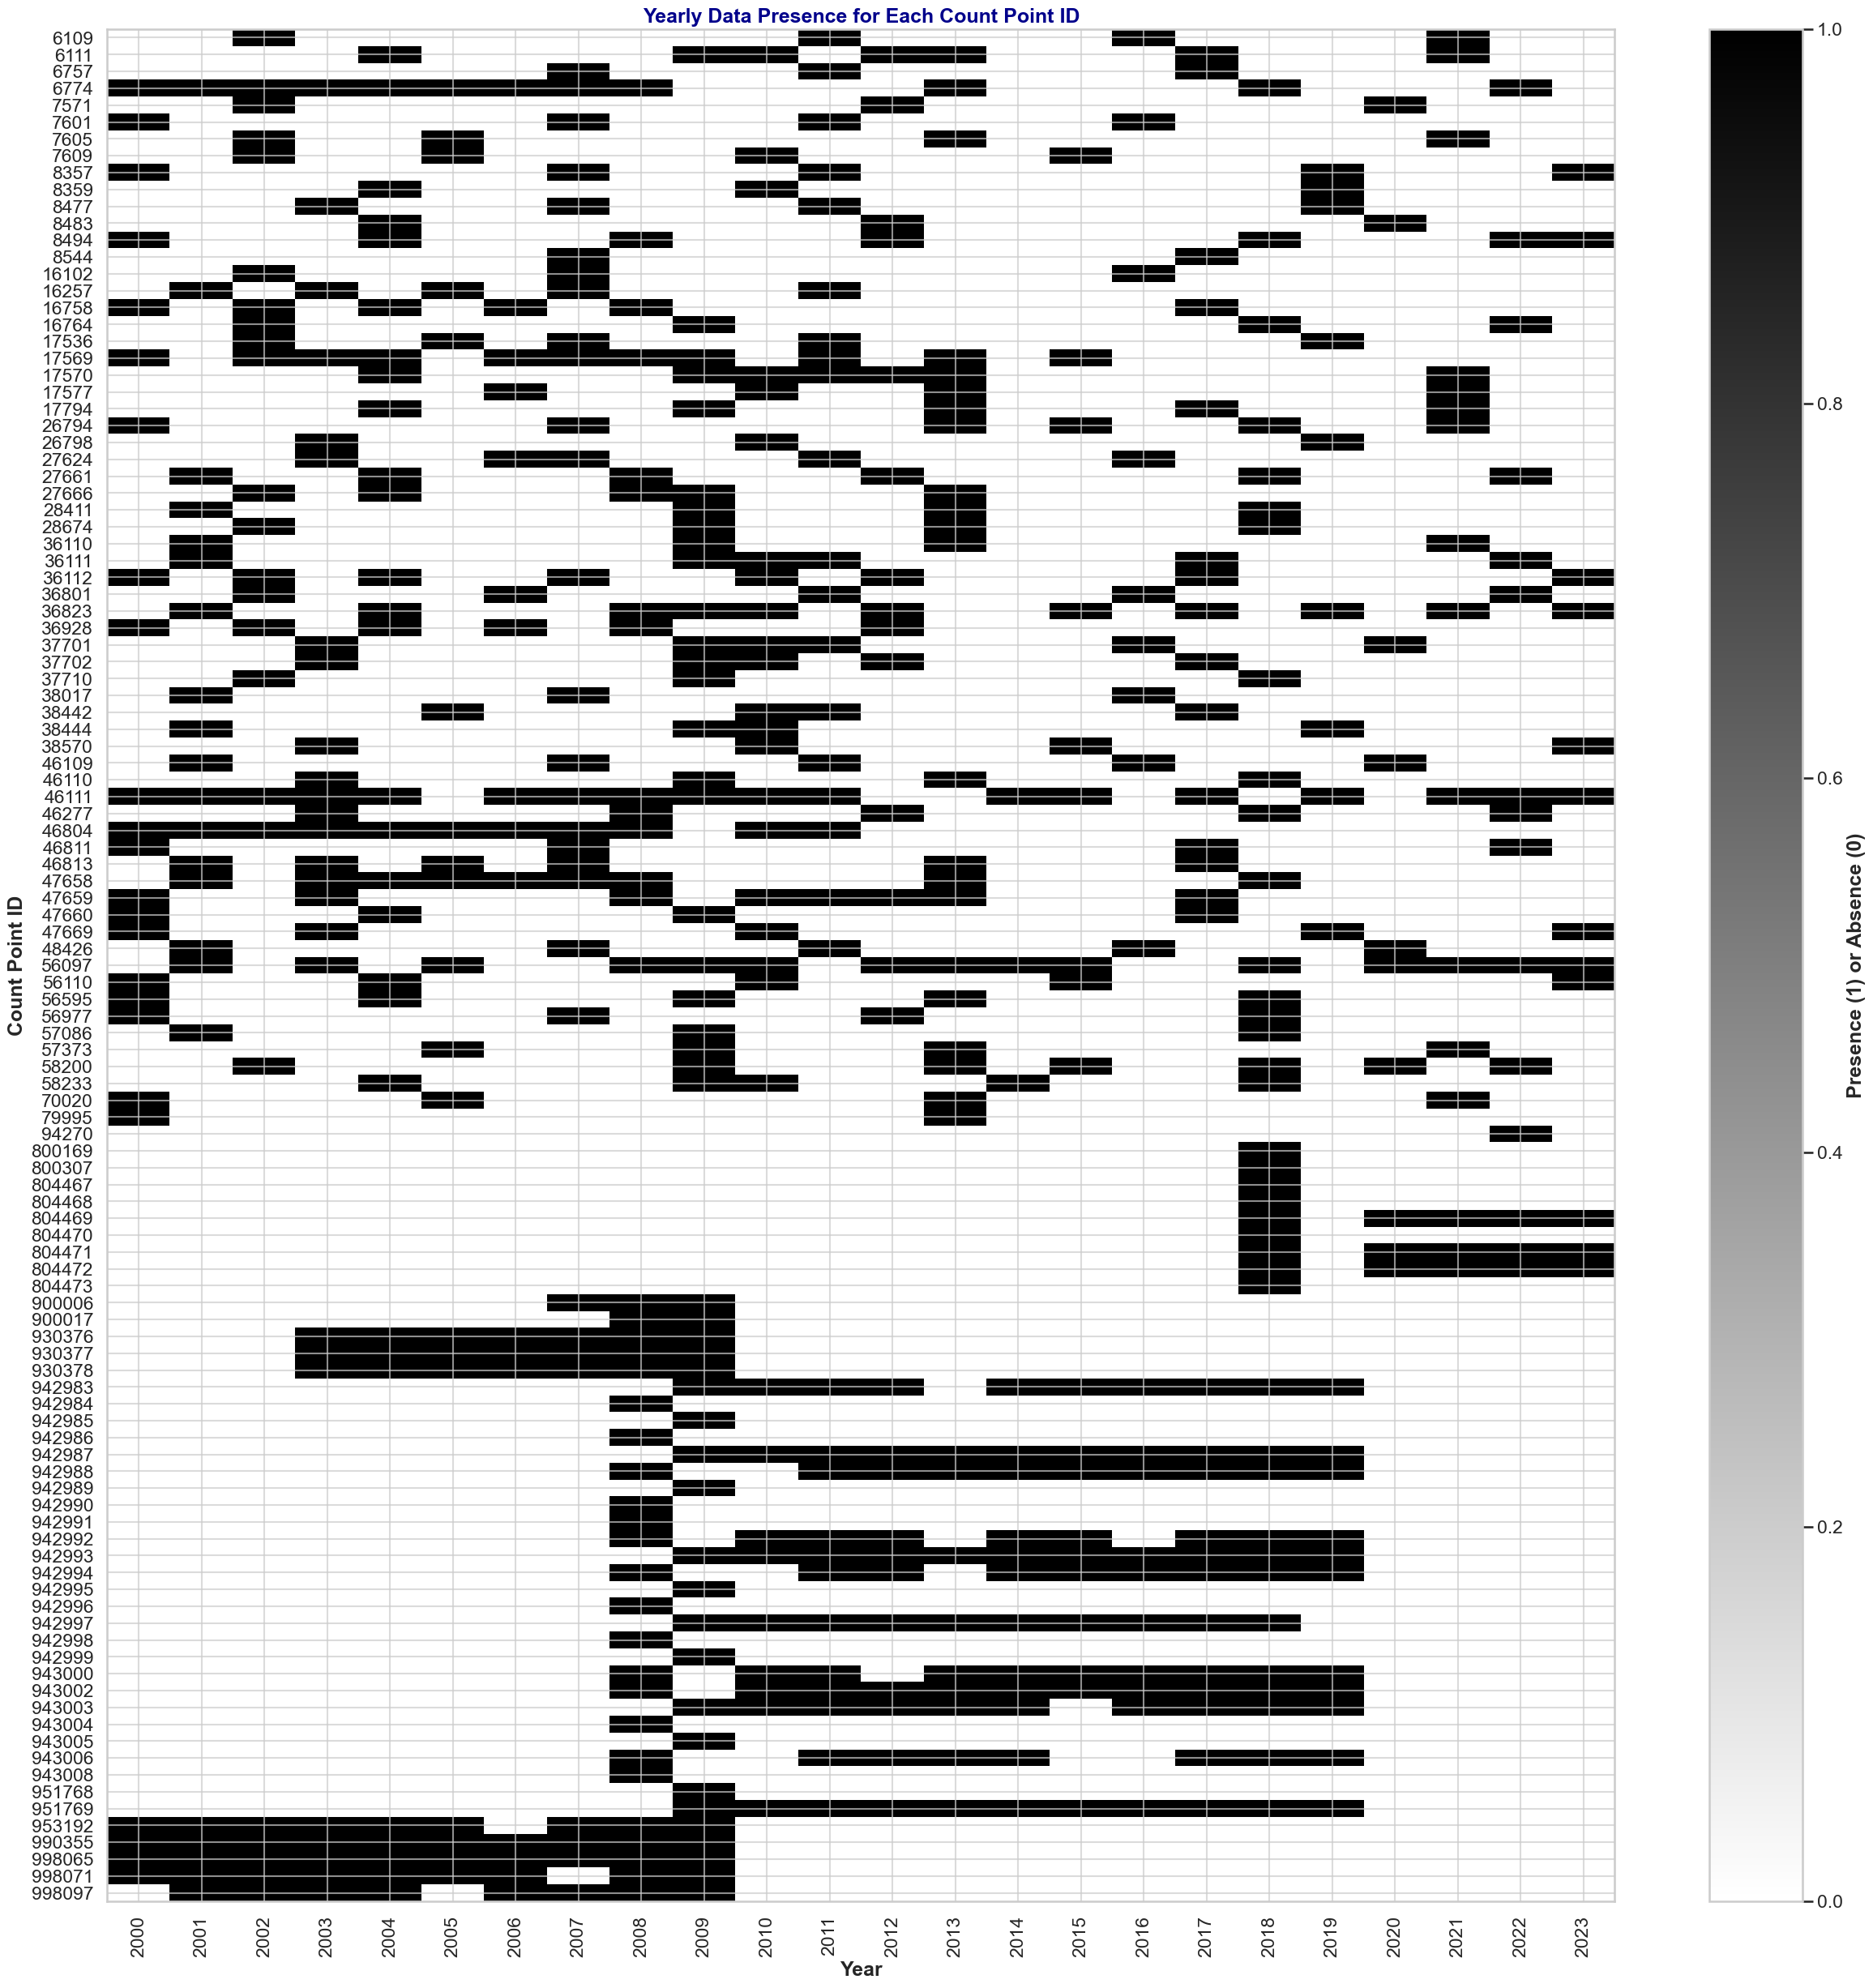

In [143]:
years = list(range(2000, 2024))
# Create an empty DataFrame for the heatmap data
heatmap_data = pd.DataFrame(0, index=tdf['count_point_id'], columns=years)


# Populate the heatmap data based on presence of years
for _, row in tdf.iterrows():
    for year in row['year']:
        if year in heatmap_data.columns:
            heatmap_data.loc[row['count_point_id'], year] = 1


# Plot the heatmap
plt.figure(figsize=(30, 30))
plt.imshow(heatmap_data, aspect='auto', cmap='binary', interpolation='none')
plt.colorbar(label='Presence (1) or Absence (0)')
plt.xlabel('Year')
plt.ylabel('Count Point ID')
plt.xticks(ticks=np.arange(len(years)), labels=years, rotation=90)
plt.yticks(ticks=np.arange(len(heatmap_data.index)), labels=heatmap_data.index)  # Use count_point_id as labels
plt.title('Yearly Data Presence for Each Count Point ID')
plt.show()

### 3.3 Counter Points (Sensors) Data Analysis
The bar chartbelow titled **"Outdated vs Current Sensors"** provides an overview of the status of traffic sensors based on their latest data availability, using 2013 as a cutoff to classify sensors as either "Outdated" or "Current." The 10-year threshold was chosen because, in traffic engineering, a decade often marks a point where data can become less representative of current conditions due to evolving traffic patterns, infrastructure changes, and shifts in vehicle technology. Sensors with data up to or beyond 2013 are labeled as "Current," indicating they still provide relevant insights, while those with only pre-2013 data are considered "Outdated" and may require updating to maintain data accuracy. The chart shows two bars, with the longer, light blue bar representing "Current Sensors," and a shorter, red bar for "Outdated Sensors," allowing a quick assessment of the sensor network’s data currency. This analysis supports decision-making for sensor maintenance and upgrade planning, ensuring data reliability in traffic monitoring systems.

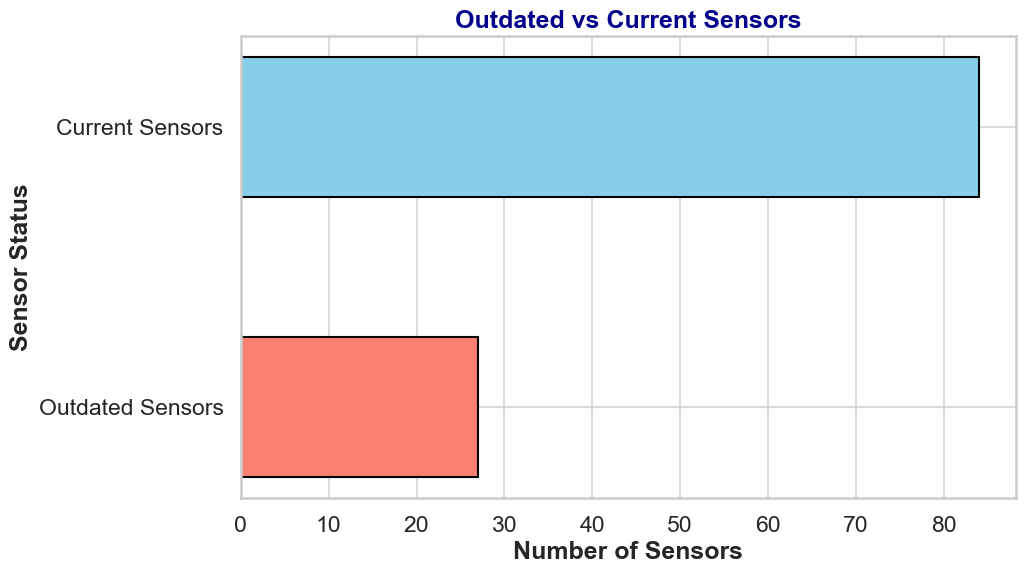

In [144]:
year_threshold=2013

x = [tdf[tdf['max_year'] < year_threshold].shape[0], tdf[tdf['max_year'] >= year_threshold].shape[0]]
y = ['Outdated Sensors', 'Current Sensors']

plt.figure(figsize=(10, 6))
plt.barh(y, x, color=['salmon', 'skyblue'], edgecolor='black', height=0.5)
plt.title('Outdated vs Current Sensors')
plt.xlabel('Number of Sensors')
plt.ylabel('Sensor Status')
plt.show()

### 3.4 Analysis of Outdated Sensor Distribution by Road Type
The bar chart titled **"Number of Major and Minor Roads with Outdated Sensors Data"** displays the count of outdated sensors across major and minor roads. In the chart, the x-axis represents the **Number of Outdated Sensors** while the y-axis differentiates **Road Type** into "Major Roads" and "Minor Roads." The shorter blue bar for major roads and the longer red bar for minor roads indicate that a greater number of outdated sensors are installed on minor roads compared to major roads, providing a quick visual comparison of outdated sensor distribution by road type.

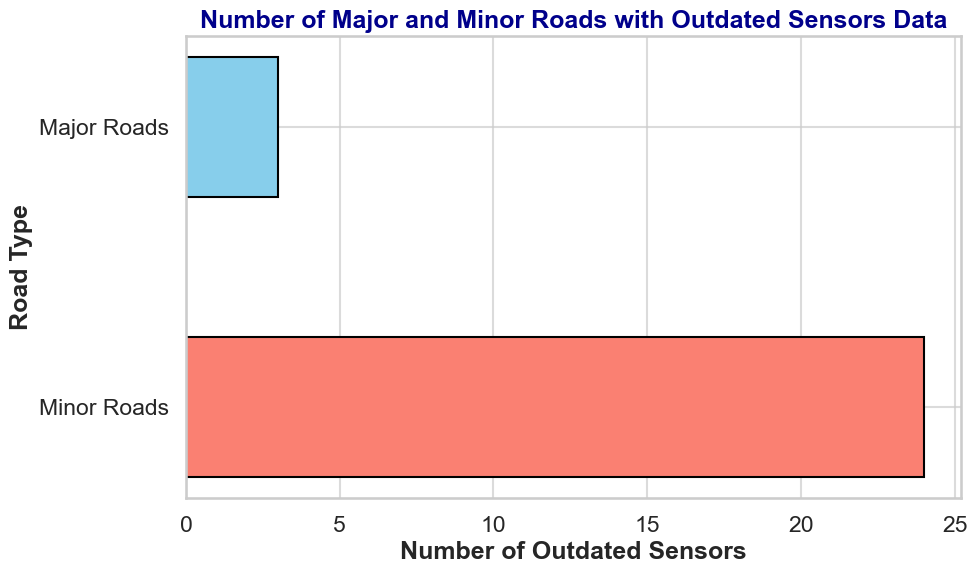

In [145]:
outdated_sensors=tdf[tdf['max_year']<year_threshold]['count_point_id'].values

odt_sens_vc= dict(count_df[count_df['count_point_id'].isin(outdated_sensors)]['road_type'].value_counts())
x = [odt_sens_vc['Minor'], odt_sens_vc['Major']]
y = ['Minor Roads', 'Major Roads']

plt.figure(figsize=(10, 6))
plt.barh(y, x, color=['salmon', 'skyblue'], edgecolor='black', height=0.5)
plt.title('Number of Major and Minor Roads with Outdated Sensors Data')
plt.xlabel('Number of Outdated Sensors')
plt.ylabel('Road Type')
plt.show()



### 3.5 Outdated Sensors AADF Traffic Trends

The following charts display the Average Annual Daily Flow (AADF) for outdated sensors, offering insights into their data trends over time. Each plot represents a different sensor's AADF across years, highlighting that many sensors have only a few data points or exhibit a consistent traffic trend over the years. Notably, sensors 16257, 36928, and 46804 have continuous data availability from 2000 to 2023, which could serve as reliable references for interpolating missing values for other sensors using a sample-weighting approach. This overview reveals the sparse data landscape for outdated sensors, supporting strategic decisions on data imputation.

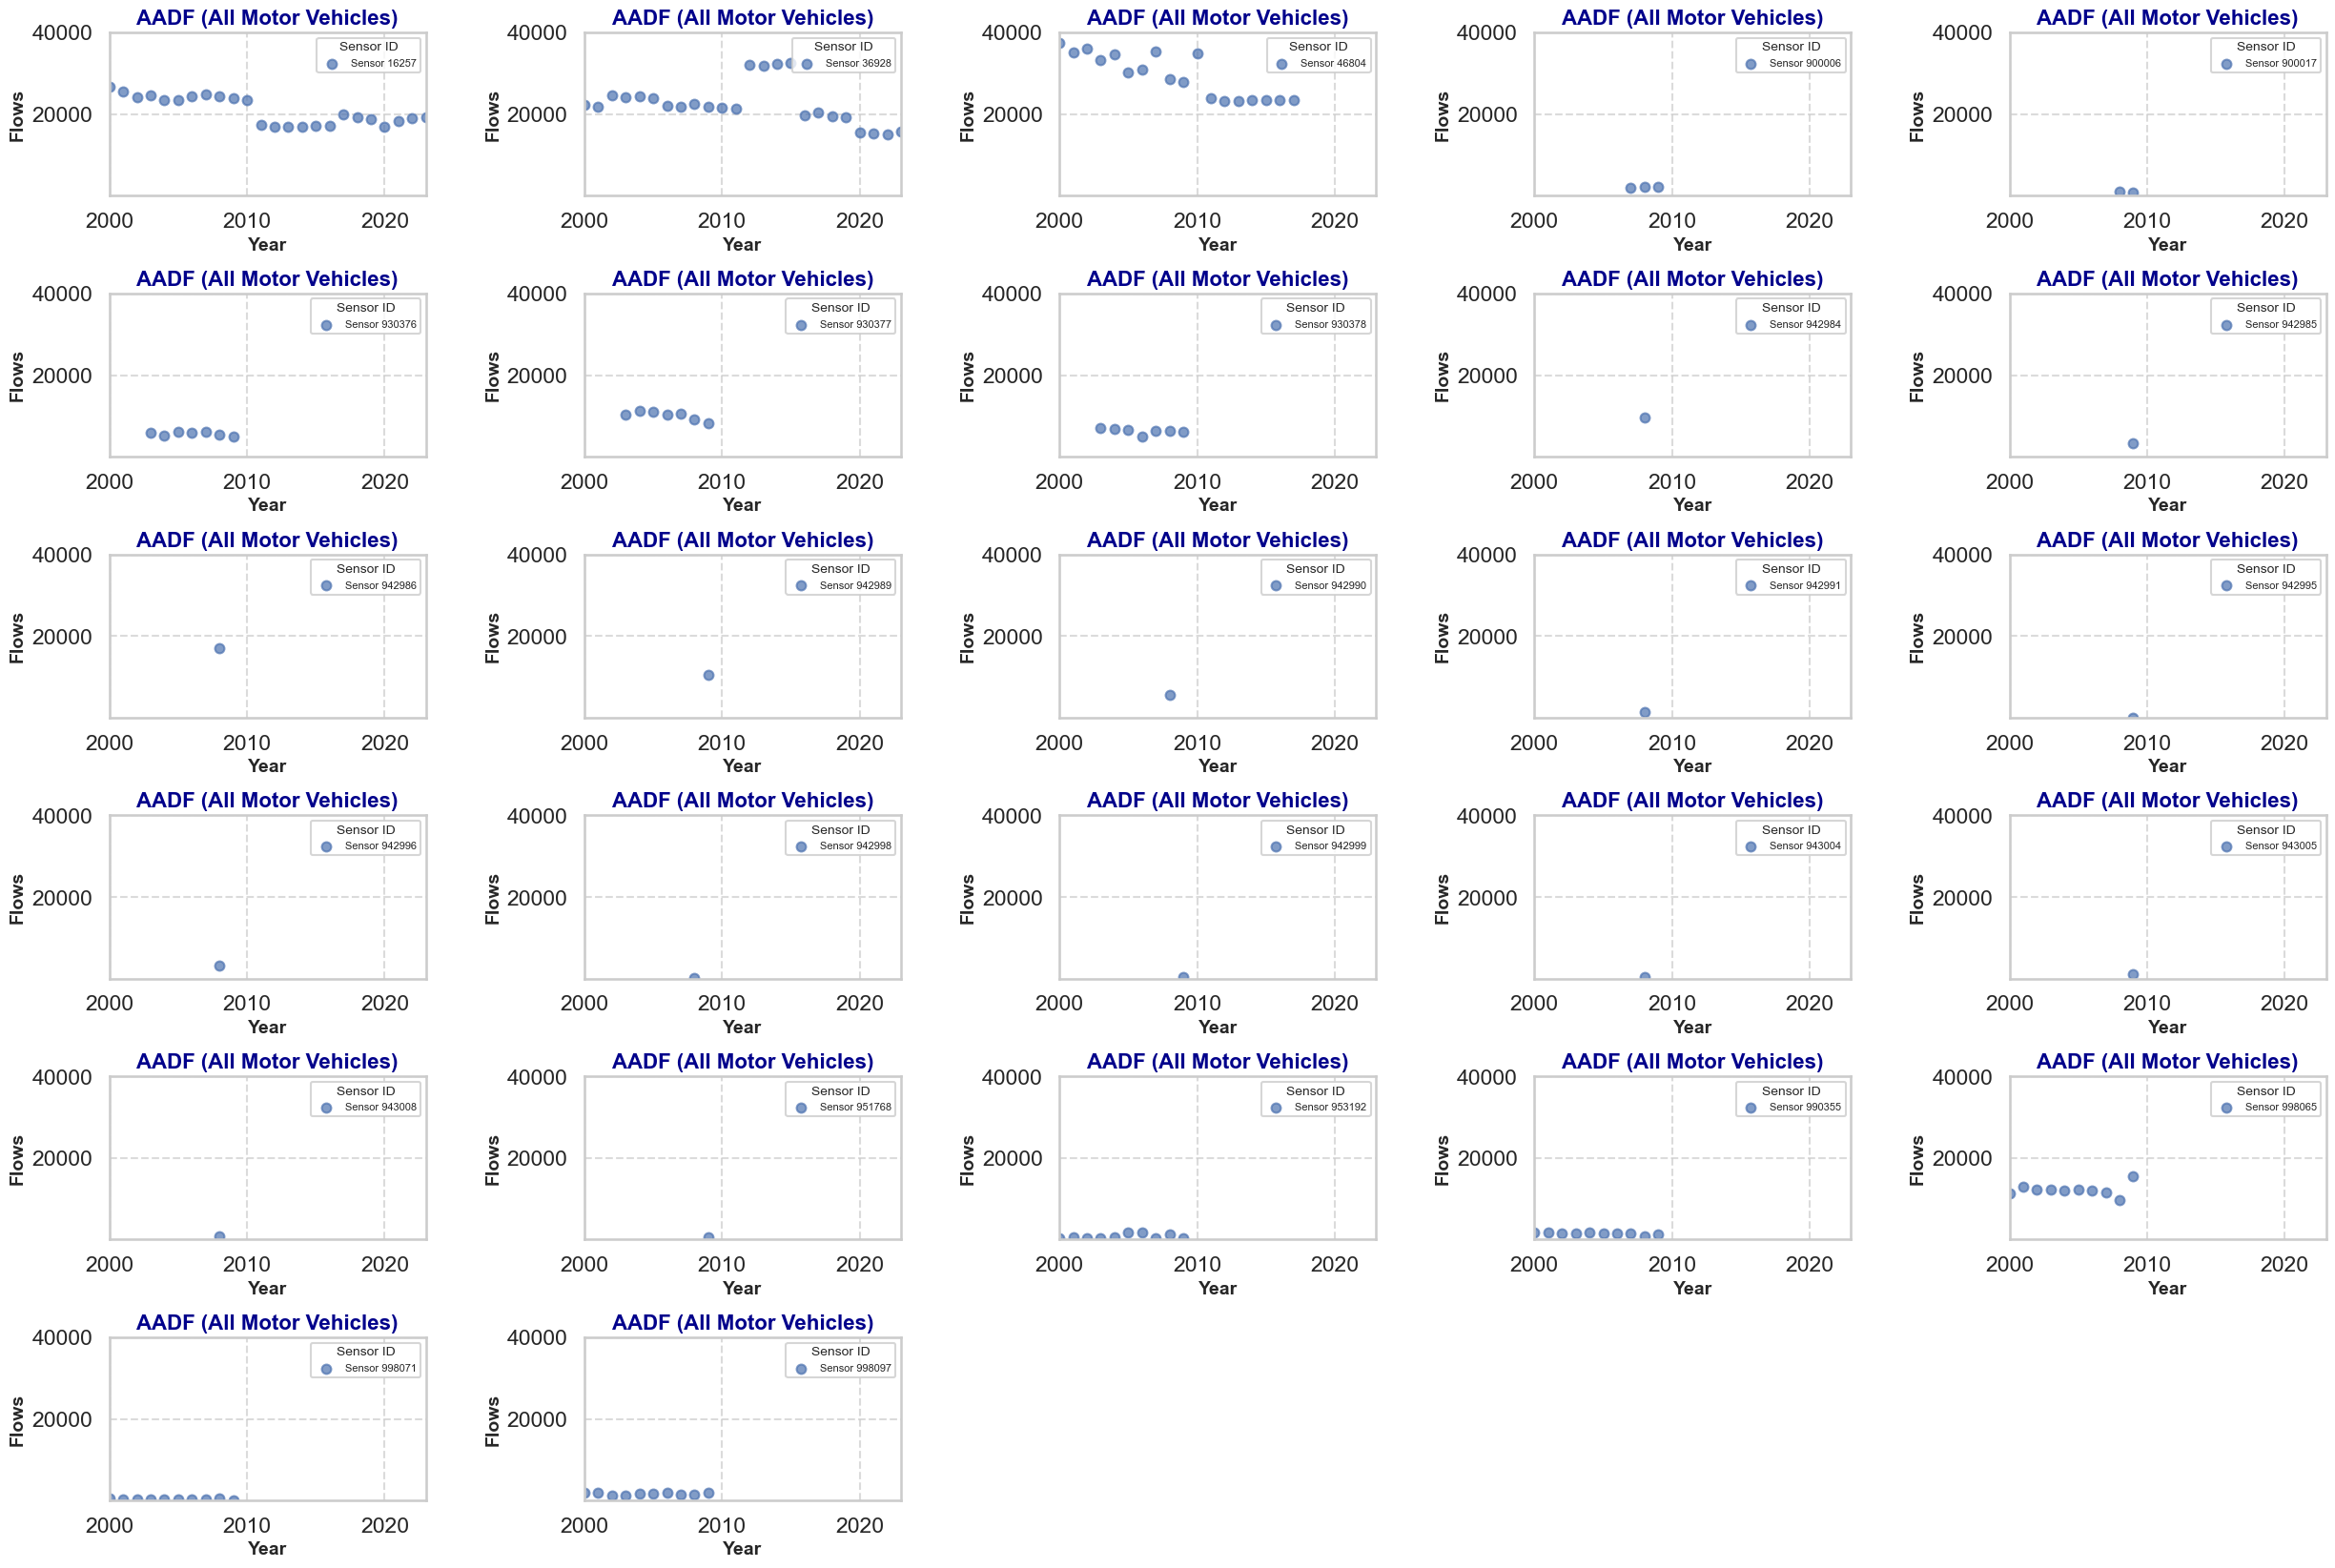

In [146]:
adtf=pd.read_csv('data/avg_annual_daily.csv')[['count_point_id','year','road_name','road_type','all_motor_vehicles']]
# Plotting a scatter plot of 'all_motor_vehicles' vs 'year' for each 'count_point_id'
adtf= adtf[adtf['count_point_id'].isin(outdated_sensors)]

fig, ax = plt.subplots(6, 5, figsize=(30, 20))  # Create a 3x3 grid of subplots
plt.subplots_adjust(wspace=0.5,hspace=0.6)

ax = ax.flatten()
count=0
for sensor_id, sensor_data in adtf.groupby('count_point_id'):
    ax[count].scatter(sensor_data['year'], sensor_data['all_motor_vehicles'], label=f"Sensor {sensor_id}", s=50, alpha=0.7)

    # Adding titles and labels with increased font sizes
    ax[count].set_title("AADF (All Motor Vehicles)", fontsize=16, fontweight='bold', color='darkblue')
    ax[count].set_xlabel("Year", fontsize=14)  
    ax[count].set_ylabel("Flows", fontsize=14)  
    ax[count].legend(title="Sensor ID", fontsize=8, title_fontsize=10)
    ax[count].grid(True, linestyle='--', alpha=0.7)
    ax[count].set_ylim([100, 40000])
    ax[count].set_xlim([2000, 2023])

    count += 1

for i in range(count, len(ax)):
    ax[i].axis('off')
plt.show()

## 4. Data Imputation 

### 4.1 Reading Average Annual Daily Flow Data

In [147]:
annaul_daily_df=pd.read_csv('data/aadf_direction.csv', dtype={'start_junction_road_name': 'string', 'end_junction_road_name': 'string'})#[['count_point_id','year','road_name','road_type','all_motor_vehicles']]
annaul_daily_df=annaul_daily_df[annaul_daily_df['count_point_id'].isin(df['count_point_id'])]
cur_col=annaul_daily_df.columns
repl_col=[c.lower() for c in cur_col]
my_dict = dict(zip(cur_col, repl_col))
annaul_daily_df.rename(columns=my_dict, inplace=True)

annaul_daily_df['total_cars_aadf']= annaul_daily_df.apply(getTotalCars,axis=1)
annaul_daily_df=annaul_daily_df[['count_point_id','direction_of_travel','year','total_cars_aadf']]
annaul_daily_df

,count_point_id,direction_of_travel,year,total_cars_aadf
18343,6109,E,2000,13638.2
18344,6109,W,2000,15465.8
18345,6109,E,2001,13542.4
18346,6109,W,2001,15334.7
18347,6109,E,2002,12815.1
...,...,...,...,...
1049914,998097,S,2007,662.2
1049915,998097,N,2008,922.6
1049916,998097,S,2008,592.6
1049917,998097,N,2009,1206.7


### 4.2 Getting Data Availability Stats

In [148]:
tdf=pd.DataFrame(annaul_daily_df.groupby(['count_point_id'])['year'].unique()).reset_index() # Groups by 'count_point_id' and lists unique years for each

# Calculating and adding columns to summarize year information for each count point:
tdf['total_years'] = tdf['year'].apply(len) # Counts the total number of unique years with data for each count point
tdf['min_year'] = tdf['year'].apply(min) # Finds the earliest (oldest) year with data availability
tdf['max_year'] = tdf['year'].apply(max) # Finds the latest (most recent) year with data availability
#tdf=tdf.merge(annaul_daily_df[['count_point_id','road_name','road_type','all_motor_vehicles']],on='count_point_id', how='left')

tdf

,count_point_id,year,total_years,min_year,max_year
0,6109,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
1,6111,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
2,6757,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
3,6774,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
4,7571,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
...,...,...,...,...,...
106,953192,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
107,990355,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
108,998065,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
109,998071,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009


#### 4.2.1 Generating a _"Compelete"_ DataFrame

In [149]:

current_sensors=tdf[tdf['max_year']>=2013]['count_point_id'].values # Getting all the current sensors' ID
raw_df=df[df['count_point_id'].isin(current_sensors)].copy() # Keeping raw traffic count valuee from only current sensors

# As shown in section 3.2, even current sensors have data for some years missing. 
# The following code generates a new dataframe with  all the combinations of years 
# and hours from 2013 to 2023.
years = range(2013, 2024)
hours = range(7, 19)  # 7 am to 6 pm
unique_points = raw_df[['count_point_id', 'direction_of_travel']].drop_duplicates() # Get unique combinations of count_point_id and direction_of_travel
complete_data = pd.MultiIndex.from_product( 
    [unique_points['count_point_id'], unique_points['direction_of_travel'], years, hours],
    names=['count_point_id', 'direction_of_travel', 'year', 'hour']
).to_frame(index=False) # Create a new DataFrame to cover all possible combinations
complete_data.drop_duplicates(subset=['count_point_id','direction_of_travel','year','hour'],inplace=True) # Deleting any duplicate record generated
complete_data # Now we have an ideal dataframe that contains each hour for each year from 2013 to 2013 for each sensor

# The following code merges the complete data with our original raw data that has missing years.
# The resultant dataframe will have complete years and hours for all the sensors. Traffic count 
# values for the years missing from our original raw data will be NA.
merged_df = pd.merge(complete_data, raw_df, on=['count_point_id', 'direction_of_travel', 'year', 'hour'], how='left') # Merge this complete set with the original data

# AADF us the annual average daily flow data for all the sensors for (almost) all the years. 
# The The line below merges AADF value with our merged_df dataframe to add AADF for every year 
# that will later be used to impute missing raw count values using sample weighting
merged_df=merged_df.merge(annaul_daily_df,on=['count_point_id','year','direction_of_travel'],how='left')

# Our orignal data does not have daily total traffic feature. The code below calculates the
# total number of daily vehicles for each year. This number will be used to calculate hourly 
# percentage with respect to total daily traffic. That percentage later be used to estimate 
# hourly traffic count values for the missing data
avg_daily_cars = (
    merged_df.groupby(['count_point_id', 'year','direction_of_travel'])['total_cars']
    .sum()
    .reset_index(name='avg_daily_cars_act')
)

merged_df = merged_df.merge(avg_daily_cars, on=['count_point_id','direction_of_travel', 'year'], how='left') # This will add new column 'avg_daily_cars_act' to original data.
merged_df['hourly_percentage'] = (merged_df['total_cars'] / merged_df['avg_daily_cars_act']) # Calculating hourly percentage

# For each sensor, the following code calculates the mean hourly percentage using all the 
# non-NA values of hours from all the years. E.g., in 2013, for sensor 6109, hourly percentage 
# of total traffic for hour 7 was 0.7 and for year 2014 it was 0.8, the mean hourly percentage 
# for hour 7 would be 0.75
hourly_percentage = (
    merged_df.dropna(subset=['hourly_percentage'])
    .groupby(['count_point_id','direction_of_travel', 'hour'])['hourly_percentage']
    .mean()
    .reset_index()
)

# The code below merges mean hourly values with original dataframe
merged_df = merged_df.merge(hourly_percentage, on=['count_point_id','direction_of_travel', 'hour'], suffixes=('', '_mean'), how='left')

# Finally, the following code imputes missing hourly values based on total_cars_addf and hourly percentage
merged_df['imputed_cars'] = merged_df.apply(
    lambda x: x['hourly_percentage_mean'] * x['total_cars_aadf'] if pd.isna(x['total_cars']) else x['total_cars'],
    axis=1
)

# One final imputation in case any NA value left because of the unavailability of AADF values.
# The code below takes the mean of imputed_cars value with respect to sensor id and hour to 
# impute missing values
merged_df['imputed_cars'] = merged_df.groupby(['count_point_id','hour'])['imputed_cars']\
                        .transform(lambda x: x.fillna(x.mean()))

# Finally, removing all those sensors whose missing values could not be imputed
merged_df.dropna(subset=['imputed_cars'],inplace=True)
merged_df

,count_point_id,direction_of_travel,year,hour,count_date,road_name,road_type,start_junction_road_name,end_junction_road_name,easting,northing,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles,total_cars,road_classification,avg_road_capacity,congestion_ratio,total_cars_aadf,avg_daily_cars_act,hourly_percentage,hourly_percentage_mean,imputed_cars
0,6109,E,2013,7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.075276,1043.648893
1,6109,E,2013,8,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.086319,1196.749094
2,6109,E,2013,9,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.074999,1039.814177
3,6109,E,2013,10,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.084058,1165.404862
4,6109,E,2013,11,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.081313,1127.347028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45931,951769,S,2023,14,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.099895,35.385714
45932,951769,S,2023,15,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.085524,43.785714
45933,951769,S,2023,16,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.079475,47.150000
45934,951769,S,2023,17,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.087450,46.085714


#### 4.2.2 Visualizing Trends in Sensor Data Availability Over Time (2000-2023) ( Same as Section 3.2)

The graph below shows the trends in sensor data availability across years, highlighting an improvement in data coverage. Notably, we now have complete time-series data with sensor values consistently available from 2013 to 2023. This uniformity in recent years ensures a robust dataset for analyzing long-term trends and patterns, as all sensors provide continuous data during this period. Such consistency is particularly useful for predictive modeling, as models can rely on a stable, uninterrupted data series to make more accurate and reliable forecasts. This availability trend marks a significant step towards achieving comprehensive data coverage across all sensors, enhancing the dataset’s value for predictive analytics.


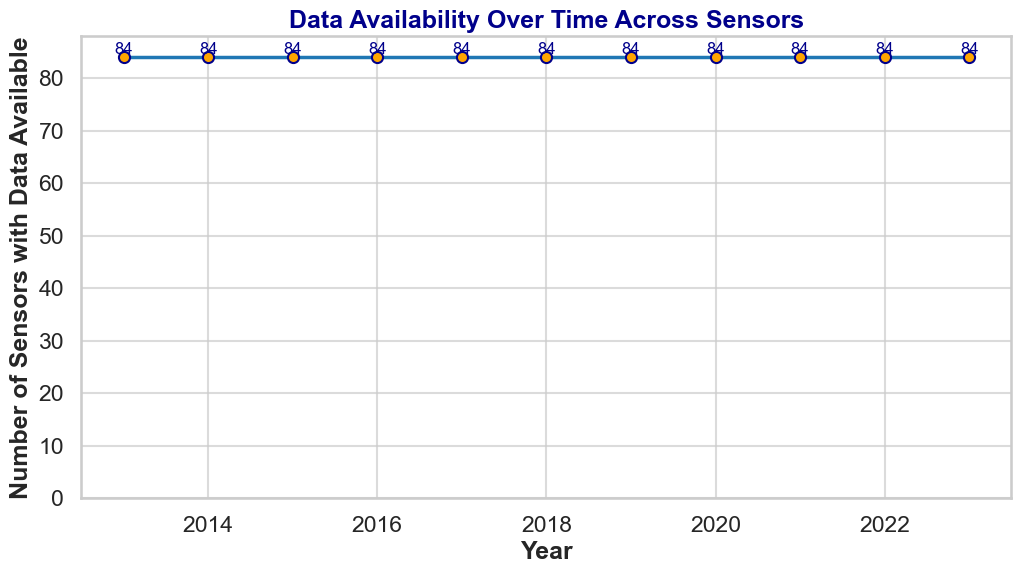

In [150]:
tdf=pd.DataFrame(merged_df[~merged_df['imputed_cars'].isna()].groupby(['count_point_id'])['year'].unique()).reset_index() # Groups by 'count_point_id' and lists unique years for each

# Calculating and adding columns to summarize year information for each count point:
tdf['total_years'] = tdf['year'].apply(len) # Counts the total number of unique years with data for each count point
tdf['min_year'] = tdf['year'].apply(min) # Finds the earliest (oldest) year with data availability
tdf['max_year'] = tdf['year'].apply(max) # Finds the latest (most recent) year with data availability

# Flattening the 'year' column to count the occurrence of each year across all sensors
years = [year for sublist in tdf['year'] for year in sublist]
year_counts = Counter(years)

# Creating lists for plotting
years_sorted = sorted(year_counts.keys())
sensor_counts = [year_counts[year] for year in years_sorted]


plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", context="talk")
plt.plot(years_sorted, sensor_counts, marker='o', linestyle='-', color='#1f77b4', linewidth=2.5, markersize=8, markerfacecolor='orange', markeredgewidth=1.5, markeredgecolor='darkblue')

plt.title("Data Availability Over Time Across Sensors")
plt.xlabel("Year")
plt.ylabel("Number of Sensors with Data Available")
for year, count in zip(years_sorted, sensor_counts):
    if count > 1:
        plt.text(year, count + 0.1, f"{count}", ha='center', va='bottom', color='darkblue', fontsize=12)

plt.grid(visible=True)
plt.ylim(0, max(sensor_counts) + 4)

# Showing the plot
plt.show()

#### 4.2.3 Saving Processed Data

In [128]:
merged_df.to_csv('data/processed_raw_count.csv',index=False)

## 4. Visualizing Congestion Points

In [129]:
df=merged_df.copy()

major_rd_df=df[(df['road_type']=='Major')&(~df['count_point_id'].isin(outdated_sensors))].copy()
minor_rd_df=df[(df['road_type']=='Minor')&(~df['count_point_id'].isin(outdated_sensors))].copy()

### 4.1 Major Roads Morning Peak Hours Congestion Spots

In [151]:
# Major Roads
df_grouped_major=pd.DataFrame(major_rd_df.groupby(['count_point_id','latitude','longitude','direction_of_travel','hour'])['congestion_ratio'].mean())
df_grouped_major.reset_index(inplace=True)
df_grouped_major['hour_category']=df_grouped_major['hour'].transform(lambda x: 'morning_peak' if x<9 else ('evening_peak' if x>15 else 'day_time'))

df_grouped_major=df_grouped_major[['count_point_id','latitude','longitude', 'direction_of_travel', 'hour', 'hour_category','congestion_ratio']]


df_maj_morning=df_grouped_major[df_grouped_major['hour_category']=='morning_peak'].copy()
df_maj_morning['density']=df_maj_morning['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_maj_morning['latitude'].mean(), df_maj_morning['longitude'].mean()], zoom_start=12)

for _, row in df_maj_morning.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m

### 4.2 Major Roads  Evening Hours Congestion Spots

In [152]:



df_maj_evening=df_grouped_major[df_grouped_major['hour_category']=='evening_peak'].copy()
df_maj_evening['density']=df_maj_evening['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_maj_evening['latitude'].mean(), df_maj_evening['longitude'].mean()], zoom_start=12)

for _, row in df_maj_evening.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m

### 4.3 Minor Roads Morning Peak Hours Congestion Spots

In [153]:
# Minor Roads
df_grouped_minor=pd.DataFrame(minor_rd_df.groupby(['count_point_id','latitude','longitude','direction_of_travel','hour'])['congestion_ratio'].mean())
df_grouped_minor.reset_index(inplace=True)
df_grouped_minor['hour_category']=df_grouped_minor['hour'].transform(lambda x: 'morning_peak' if x<9 else ('evening_peak' if x>15 else 'day_time'))

df_grouped_minor=df_grouped_minor[['count_point_id','latitude','longitude', 'direction_of_travel', 'hour', 'hour_category','congestion_ratio']]
df_grouped_minor


df_grouped_minor=df_grouped_minor[df_grouped_minor['hour_category']=='morning_peak'].copy()
df_grouped_minor['density']=df_grouped_minor['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_grouped_minor['latitude'].mean(), df_grouped_minor['longitude'].mean()], zoom_start=12)

for _, row in df_grouped_minor.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m

### 4.4 Minor Roads Evening Peak Hours Congestion Spots

In [154]:

# Minor Roads
df_grouped_minor=pd.DataFrame(minor_rd_df.groupby(['count_point_id','latitude','longitude','direction_of_travel','hour'])['congestion_ratio'].mean())
df_grouped_minor.reset_index(inplace=True)
df_grouped_minor['hour_category']=df_grouped_minor['hour'].transform(lambda x: 'morning_peak' if x<9 else ('evening_peak' if x>15 else 'day_time'))

df_grouped_minor=df_grouped_minor[['count_point_id','latitude','longitude', 'direction_of_travel', 'hour', 'hour_category','congestion_ratio']]

df_grouped_minor=df_grouped_minor[df_grouped_minor['hour_category']=='evening_peak'].copy()
df_grouped_minor['density']=df_grouped_minor['congestion_ratio'].apply(lambda x: x*20 if x<=1 else x*20)

# Create a map centered at the average latitude and longitude
m = folium.Map(location=[df_grouped_minor['latitude'].mean(), df_grouped_minor['longitude'].mean()], zoom_start=12)

for _, row in df_grouped_minor.iterrows():
    fill_color = 'red' if row['congestion_ratio'] > 1 else 'green'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=row['congestion_ratio']*20,  # Adjust scaling (you can change it if circles are too big or small)
        color=None,  # No border
        fill=True,  # Enable fill
        fill_color=fill_color,  # Fill color
        fill_opacity=0.3  # Make the fill more transparent
    ).add_to(m)

    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f'ID: {row["count_point_id"]}\nDensity: {row["congestion_ratio"]}'
    ).add_to(m)

m